In [3]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator
from trace_IO import *
import matplotlib.pyplot as plt
import DELightStyle
plt.rcParams['font.family'] = 'DejaVu Sans'  # Matplotlib's default font

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('./config.yaml')
ts = TraceSimulator(config)

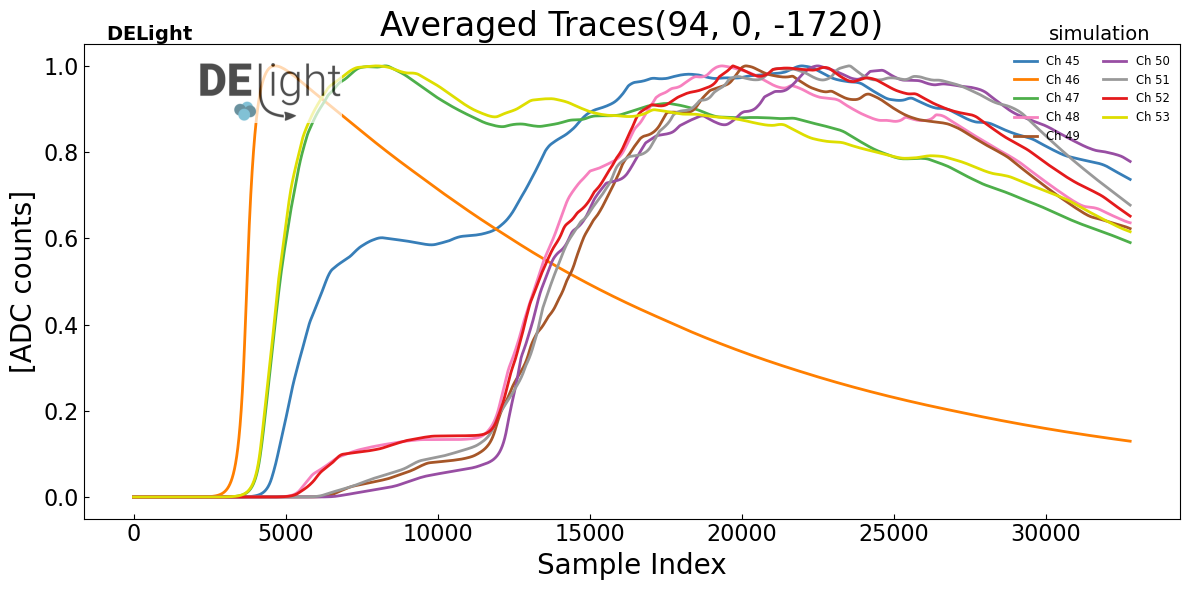

In [16]:
num_sets = 10
start_channel = 45
x_val = 94
y_val = 0
z_val = -1720

# Generate the first trace to determine shapes
trace= ts.generate(E=30000, x = x_val, y = y_val, z=z_val, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
num_channels, num_samples = trace[0].shape

# Preallocate array to hold traces for selected channels
trace_accumulator = np.zeros((num_channels - start_channel, num_samples))

# Accumulate traces
for _ in range(num_sets):
    trace = ts.generate(E=30000, x = x_val, y = y_val, z= z_val, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
    trace_accumulator += trace[0][start_channel:]

# Average over all sets
avg_traces = trace_accumulator / num_sets

# Normalize each channel to its maximum
normalized_traces = avg_traces / np.max(np.abs(avg_traces), axis=1, keepdims=True)

# Plot the normalized average traces
fig, ax = plt.subplots(figsize=(12, 6))  # Get both fig and ax objects
for i, ch in enumerate(normalized_traces):
    ax.plot(ch, label=f'Ch {start_channel + i}')

ax.set_title(f"Averaged Traces({x_val}, {y_val}, {z_val})")
ax.set_xlabel("Sample Index")
ax.set_ylabel("[ADC counts]")
ax.legend(loc='upper right', fontsize='small', ncol=2)

# Apply DELightStyle elements with correct ax reference
DELightStyle.display_text(ax, r'$\mathbf{DELight}$', x0=0.02, y0=1.045)
DELightStyle.display_delight_logo(ax, x0=0.02, y0=0.98)
DELightStyle.display_text(ax, "simulation", x0=0.88, y0=1.04)

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt

xy_coordinates = [
    (0, 0),
    (94, 0),
    (-94, 0),
    (-66.46804, 66.46804),
    (66.46804, 66.46804)
]
fixed_z = -1720
Energy = 2000
num_sets = 1000  # Make sure this is defined
start_channel = 45  # Assuming channel 45 is the first channel of interest

# Dictionaries to store normalized traces
normalized_ch45_by_xy = {}
normalized_other_channels_by_xy = {}

# Determine shapes
initial_trace_for_shape = ts.generate(E=Energy, x=0, y=0, z=fixed_z, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
num_channels, num_samples = initial_trace_for_shape[0].shape

# Process traces for each (x, y)
for x_val, y_val in xy_coordinates:
    print(f"Processing traces for (x, y) = ({x_val}, {y_val})")

    ch45_accumulator = np.zeros(num_samples)
    other_ch_accumulator = np.zeros(num_samples)

    for _ in range(num_sets):
        trace = ts.generate(E=Energy, x=x_val, y=y_val, z=fixed_z, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)[0]
        
        ch45_accumulator += trace[start_channel]  # Channel 45 only
        other_ch_accumulator += np.sum(trace[start_channel + 1:], axis=0)  # Remaining channels

    avg_ch45_trace = ch45_accumulator / num_sets
    avg_other_ch_trace = other_ch_accumulator / num_sets

    # Normalize each
    max_ch45 = np.max(np.abs(avg_ch45_trace))
    norm_ch45 = avg_ch45_trace / max_ch45 if max_ch45 > 1e-9 else avg_ch45_trace

    max_others = np.max(np.abs(avg_other_ch_trace))
    norm_others = avg_other_ch_trace / max_others if max_others > 1e-9 else avg_other_ch_trace

    normalized_ch45_by_xy[f"({x_val}, {y_val})"] = norm_ch45
    normalized_other_channels_by_xy[f"({x_val}, {y_val})"] = norm_others

# Plot Channel 45 only
plt.figure(figsize=(14, 6))
for xy_label, data in normalized_ch45_by_xy.items():
    plt.plot(data, label=f'x,y = {xy_label}')
plt.title(f"Normalized Avg of Channel 45 (Z = {fixed_z})")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.legend(title="X,Y-Position")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot all other channels (summed)
plt.figure(figsize=(14, 6))
for xy_label, data in normalized_other_channels_by_xy.items():
    plt.plot(data, label=f'x,y = {xy_label}')
plt.title(f"Normalized Avg of Other Channels (Z = {fixed_z})")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.legend(title="X,Y-Position")
plt.grid(True)
plt.tight_layout()
plt.show()


Processing traces for (x, y) = (0, 0)


KeyboardInterrupt: 

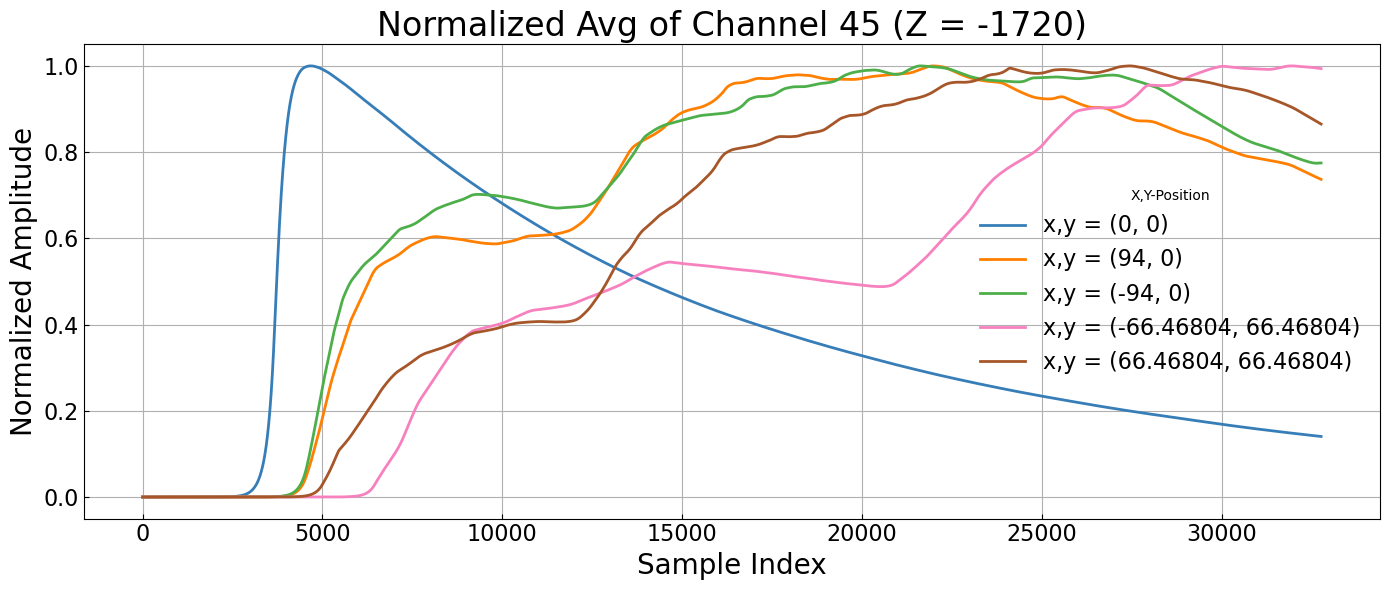

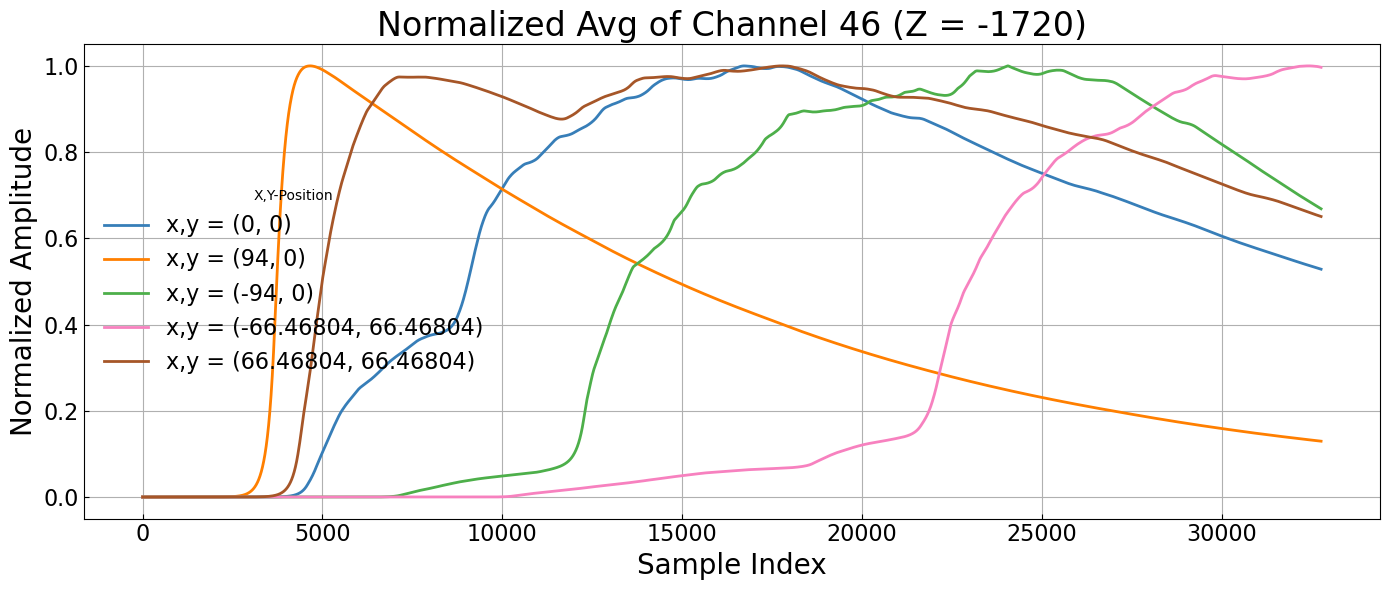

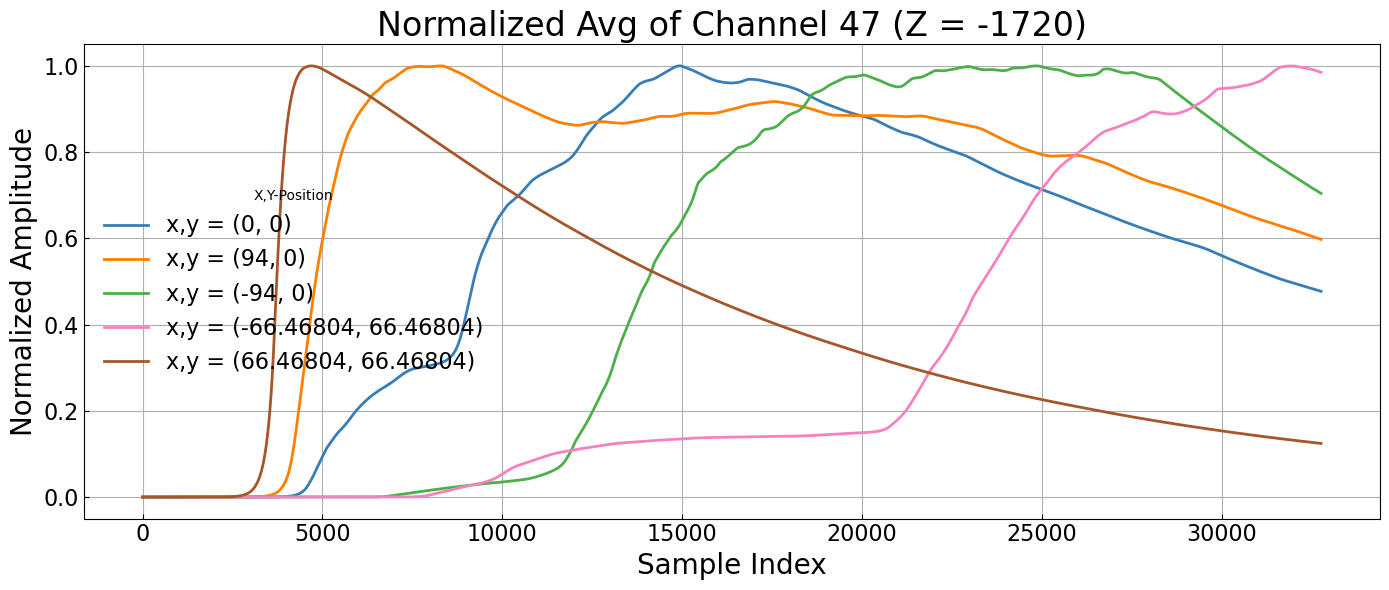

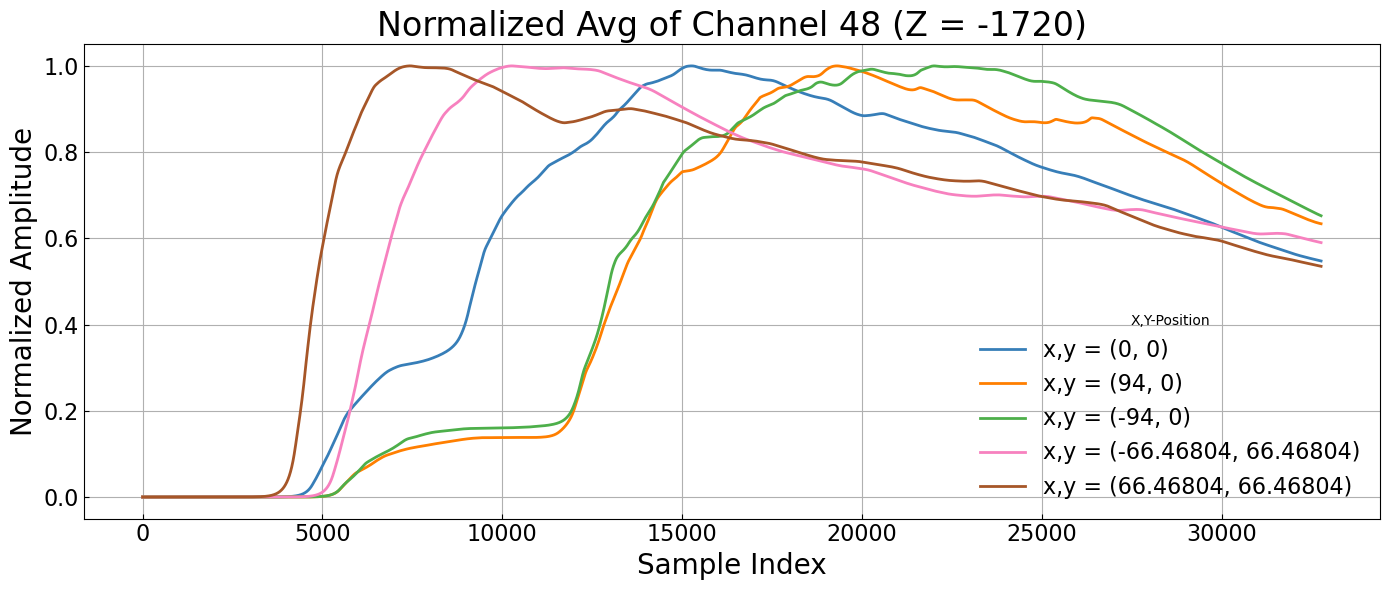

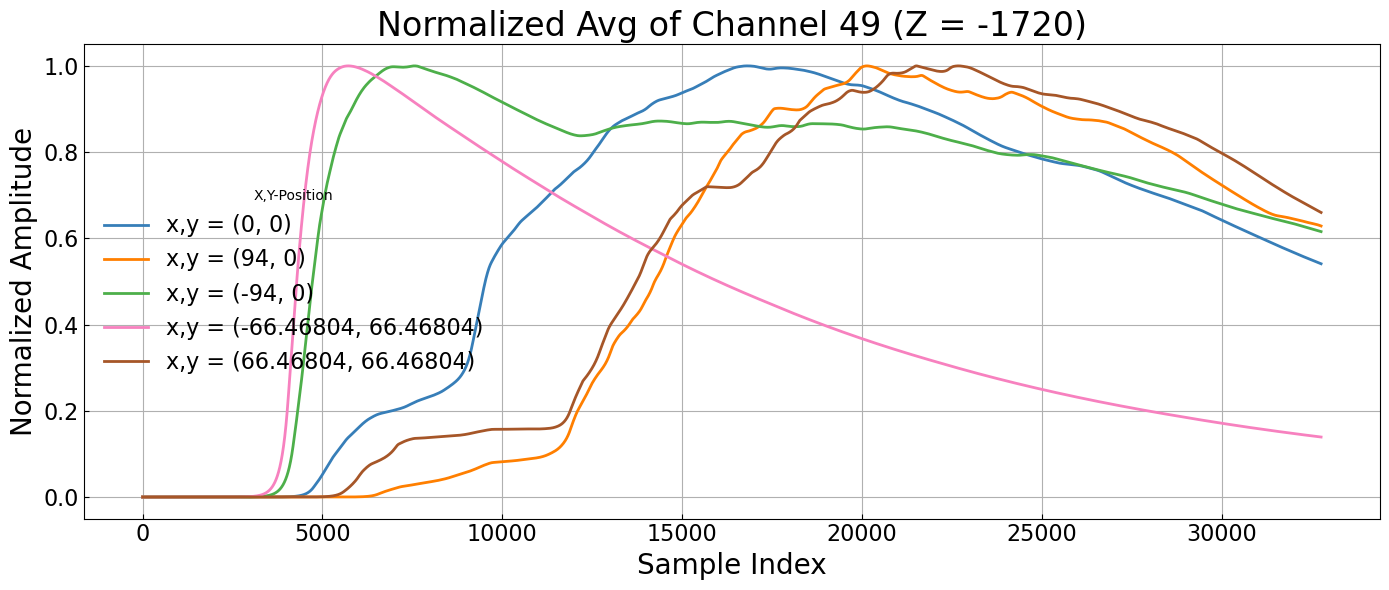

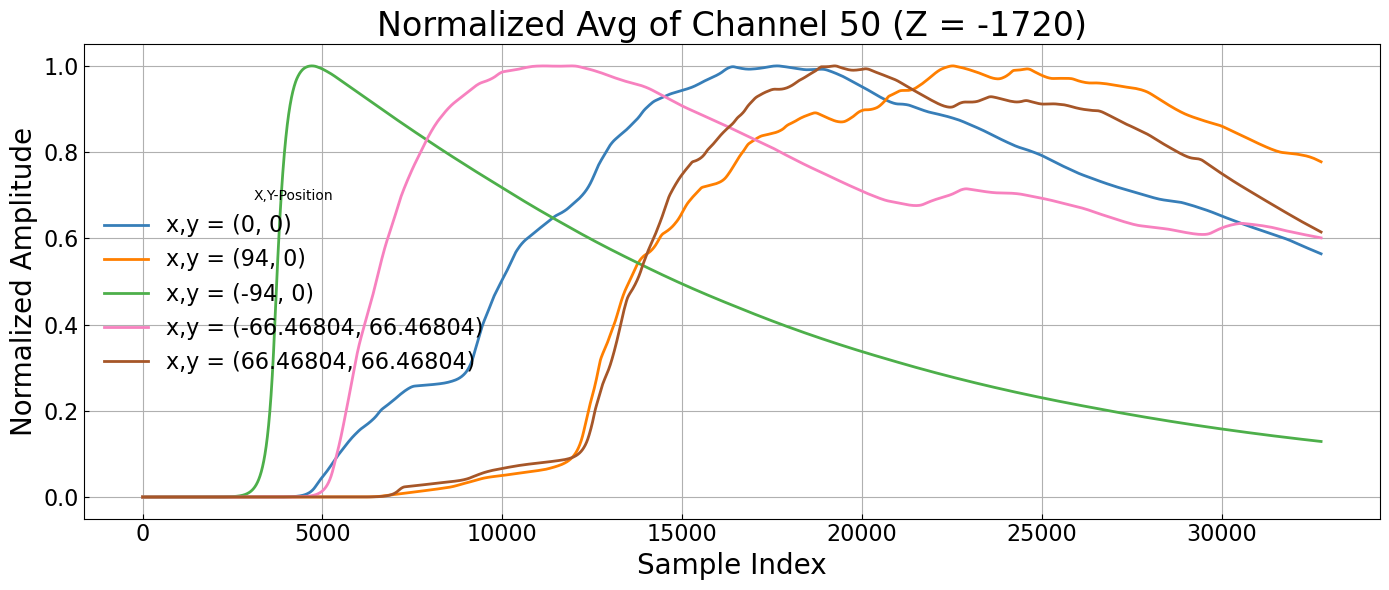

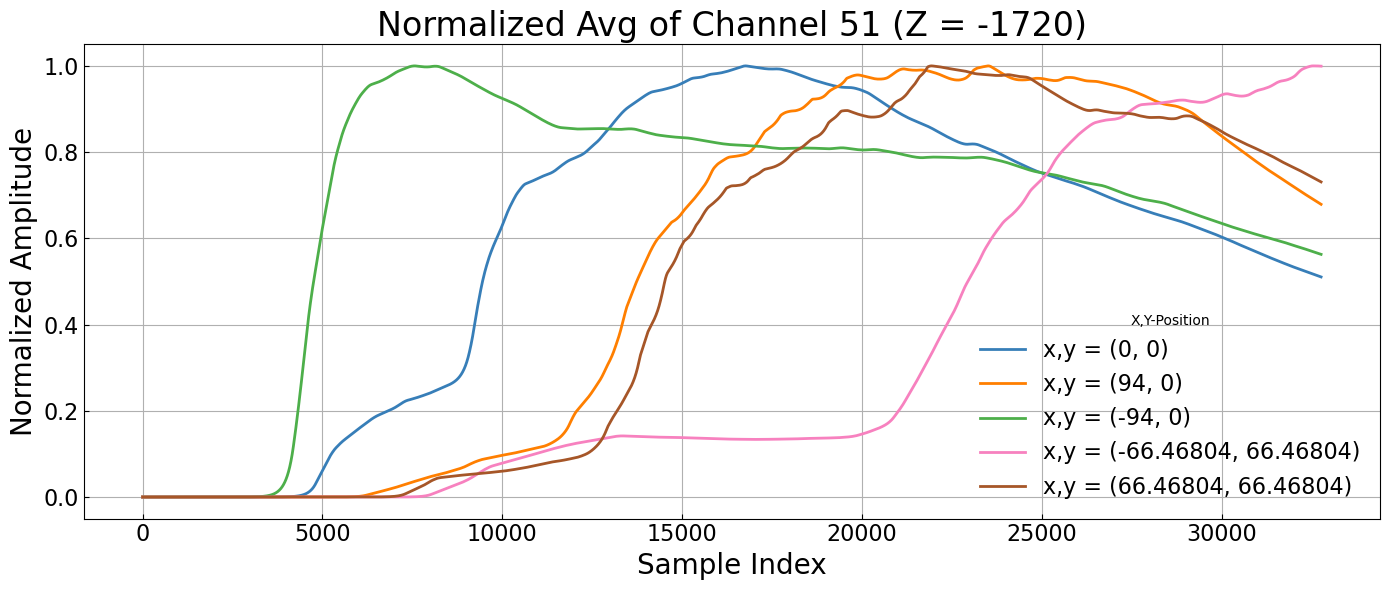

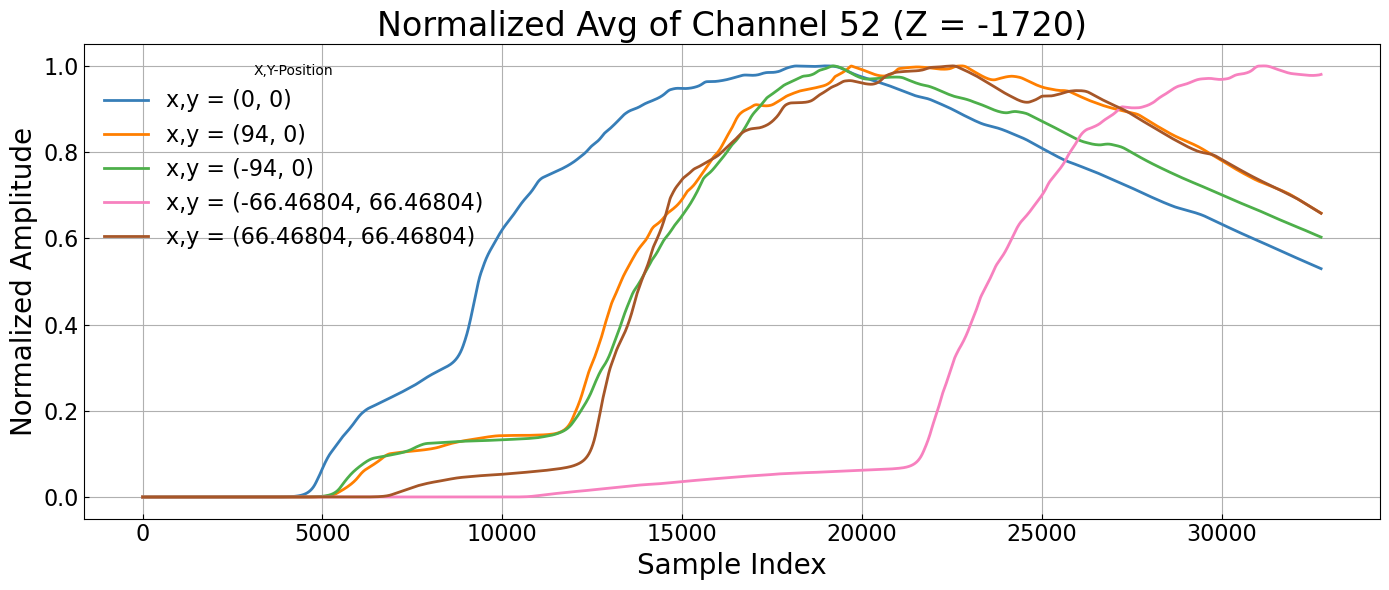

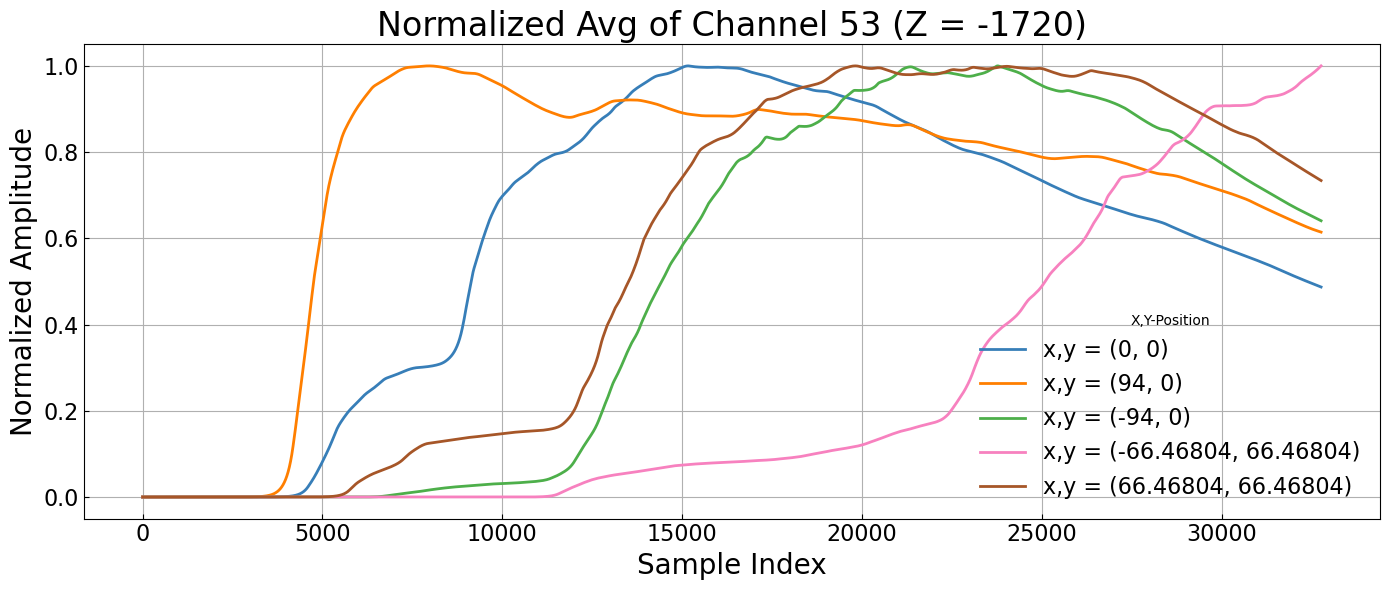

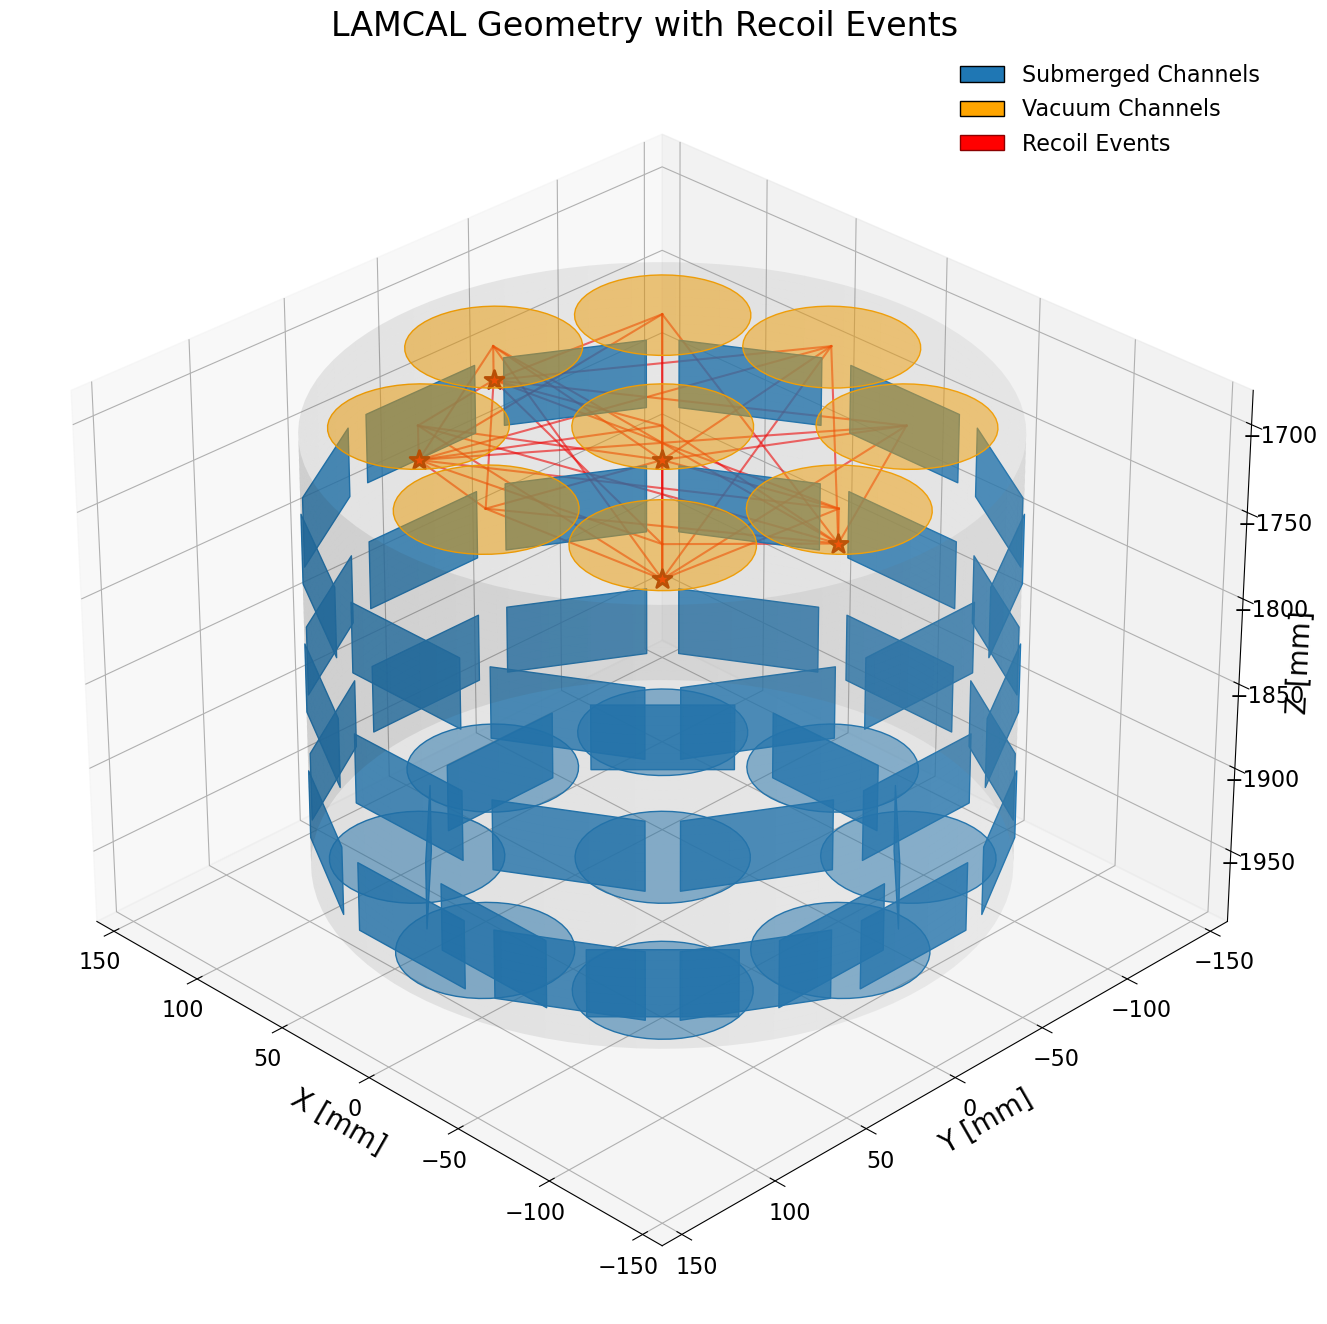

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch

# === SETTINGS ===
xy_coordinates = [
    (0, 0),
    (94, 0),
    (-94, 0),
    (-66.46804, 66.46804),
    (66.46804, 66.46804)
]
fixed_z = -1720
Energy = 2000
num_sets = 100
start_channel = 45

# === TRACE AGGREGATION PER CHANNEL ===
normalized_traces_by_channel_and_xy = {}

initial_trace = ts.generate(E=Energy, x=0, y=0, z=fixed_z, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)
num_channels, num_samples = initial_trace[0].shape

# Initialize storage for each channel
for ch in range(start_channel, num_channels):
    normalized_traces_by_channel_and_xy[ch] = {}

# Aggregate traces for each (x,y) position
for x_val, y_val in xy_coordinates:
    trace_sum = np.zeros((num_channels, num_samples))
    for _ in range(num_sets):
        trace = ts.generate(E=Energy, x=x_val, y=y_val, z=fixed_z, no_noise=True, type_recoil='NR', quantize=False, phonon_only=True)[0]
        trace_sum += trace
    trace_avg = trace_sum / num_sets

    for ch in range(start_channel, num_channels):
        ch_trace = trace_avg[ch]
        norm = np.max(np.abs(ch_trace))
        if norm > 1e-9:
            normalized_trace = ch_trace / norm
        else:
            normalized_trace = ch_trace
        normalized_traces_by_channel_and_xy[ch][f"({x_val}, {y_val})"] = normalized_trace

# === PLOT EACH CHANNEL INDIVIDUALLY ===
for ch in range(start_channel, num_channels):
    fig, ax = plt.subplots(figsize=(14, 6))
    for label, trace in normalized_traces_by_channel_and_xy[ch].items():
        ax.plot(trace, label=f'x,y = {label}')
    ax.set_title(f"Normalized Avg of Channel {ch} (Z = {fixed_z})")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Normalized Amplitude")
    ax.legend(title="X,Y-Position")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# === MMC 3D GEOMETRY WITH RECOIL LOCATIONS ===
position_file = '/ceph/bmaier/delight/share/TraceSimulator/position_MMC.dat'
positions = np.loadtxt(position_file)
mmc_ids = positions[:, 0].astype(int)
x, y, z = positions[:, 1], positions[:, 2], positions[:, 3]
mask_submerged = mmc_ids < 2000
mask_vacuum = mmc_ids >= 2000

r_cylinder = np.sqrt(x**2 + y**2).max()
z_min, z_max = z.min(), z.max()
theta = np.linspace(0, 2 * np.pi, 100)
z_cyl = np.linspace(z_min, z_max, 50)
theta_grid, z_grid = np.meshgrid(theta, z_cyl)
x_cyl = r_cylinder * np.cos(theta_grid)
y_cyl = r_cylinder * np.sin(theta_grid)

width, height = 60, 40
def create_disk(center_z, radius=5, resolution=50):
    angles = np.linspace(0, 2 * np.pi, resolution)
    x_disk = radius * np.cos(angles)
    y_disk = radius * np.sin(angles)
    z_disk = np.full_like(x_disk, center_z)
    return list(zip(x_disk, y_disk, z_disk))

fig = plt.figure(figsize=(13, 18))
ax = fig.add_subplot(111, projection='3d')

# Submerged rectangles
for xi, yi, zi in zip(x[mask_submerged], y[mask_submerged], z[mask_submerged]):
    radius = np.sqrt(xi**2 + yi**2)
    if radius == 0:
        continue
    angle = np.arctan2(yi, xi)
    angles = [angle - width / (2 * radius), angle + width / (2 * radius)]
    zs = [zi - height / 2, zi + height / 2]
    rect_pts = []
    for a in angles:
        for z_ in zs:
            rect_pts.append([radius * np.cos(a), radius * np.sin(a), z_])
    verts = [[rect_pts[0], rect_pts[1], rect_pts[3], rect_pts[2]]]
    ax.add_collection3d(Poly3DCollection(verts, color='#1f77b4', alpha=0.8))

# Top and bottom disks
top_disk_centers = []
z_tol = 1e-1
top_mask = np.abs(z - z.max()) < z_tol
bottom_mask = np.abs(z - z.min()) < z_tol
disk_radius = 35

for xi, yi, zi in zip(x[top_mask], y[top_mask], z[top_mask]):
    angle = np.arctan2(yi, xi)
    radius = np.sqrt(xi**2 + yi**2)
    cx, cy = radius * np.cos(angle), radius * np.sin(angle)
    top_disk_centers.append((cx, cy, zi))
    disk = create_disk(zi, radius=disk_radius)
    disk = [(cx + dx, cy + dy, zi) for dx, dy, zi in disk]
    ax.add_collection3d(Poly3DCollection([disk], color='orange', alpha=0.5))

for xi, yi, zi in zip(x[bottom_mask], y[bottom_mask], z[bottom_mask]):
    angle = np.arctan2(yi, xi)
    radius = np.sqrt(xi**2 + yi**2)
    cx, cy = radius * np.cos(angle), radius * np.sin(angle)
    disk = create_disk(zi, radius=disk_radius)
    disk = [(cx + dx, cy + dy, zi) for dx, dy, zi in disk]
    ax.add_collection3d(Poly3DCollection([disk], color='#1f77b4', alpha=0.5))

# === RECOIL POSITIONS ===
for x_recoil, y_recoil in xy_coordinates:
    ax.scatter(x_recoil, y_recoil, fixed_z, c='red', s=200, marker='*', edgecolors='darkred', linewidth=2)
    for cx, cy, cz in top_disk_centers:
        ax.plot([x_recoil, cx], [y_recoil, cy], [fixed_z, cz], 'r-', linewidth=1.5, alpha=0.6)

# === CYLINDER AND FORMAT ===
ax.plot_surface(x_cyl, y_cyl, z_grid, alpha=0.1, color='gray', linewidth=0, zorder=0)
ax.set_title("LAMCAL Geometry with Recoil Events", fontsize=24)
ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.view_init(elev=30, azim=135)

legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='k', label='Submerged Channels'),
    Patch(facecolor='orange', edgecolor='k', label='Vacuum Channels'),
    Patch(facecolor='red', edgecolor='darkred', label='Recoil Events'),
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()
